# Dangerous Diamonds

This notebook demonstrates an issue in the wonderful "diamonds" dataset e.g. available in package "plotnine". The issue is that 26% of all rows are duplicates in price and the four "C" variables. They only differ in perspective variables as if the same diamond would have been measured from different angles.

## All together

In [1]:
import numpy as np
import pandas as pd
from plotnine.data import diamonds

# Variable groups
cat_vars = ["cut", "color", "clarity"]
xvars = cat_vars + ["carat"]
all_vars = xvars + ["price"]

print("Shape: ", diamonds.shape)

# Add id and id_size
df = diamonds.copy()
df["id"] = df.groupby(all_vars).ngroup()
df["id_size"] = df.groupby(all_vars)["price"].transform(len)
df.sort_values("id", inplace=True)

print(f'Proportion of dupes: {1 - df["id"].max() / df.shape[0]:.0%}')

print("Random examples")
print(df[df.id_size > 1].head(10))

print("Most frequent")
print(df.sort_values(["id_size", "id"]).tail(13))

print("A random large diamond appearing multiple times")
df[df.id_size > 3].sort_values("carat").tail(6)

Shape:  (53940, 10)
Proportion of dupes: 26%
Random examples
       carat   cut color clarity  depth  table  price     x     y     z  id  \
49816    0.7  Fair     D     SI2   65.6   55.0   2167  5.59  5.50  3.64  11   
49827    0.7  Fair     D     SI2   64.5   60.0   2167  5.53  5.47  3.55  11   
2535     0.9  Fair     D     SI2   64.7   54.0   3205  6.10  6.04  3.93  20   
2533     0.9  Fair     D     SI2   65.9   59.0   3205  6.00  5.95  3.94  20   
2536     0.9  Fair     D     SI2   65.7   60.0   3205  5.98  5.93  3.91  20   
2534     0.9  Fair     D     SI2   66.0   58.0   3205  6.00  5.97  3.95  20   
2537     0.9  Fair     D     SI2   64.7   59.0   3205  6.09  5.99  3.91  20   
3839     0.9  Fair     D     SI2   64.9   57.0   3473  6.03  5.98  3.90  21   
3841     0.9  Fair     D     SI2   64.5   61.0   3473  6.10  6.00  3.90  21   
6029     1.0  Fair     D     SI2   65.0   56.0   3965  6.27  6.23  4.06  29   

       id_size  
49816        2  
49827        2  
2535         5  
2

,carat,cut,color,clarity,depth,table,price,x,y,z,id,id_size
26848,2.01,Premium,I,VS2,62.7,58.0,16778,7.98,7.94,4.99,24015,6
26849,2.01,Premium,I,VS2,59.2,62.0,16778,8.17,8.14,4.83,24015,6
26850,2.01,Premium,I,VS2,62.6,59.0,16778,8.04,8.01,5.02,24015,6
26852,2.01,Premium,I,VS2,60.5,60.0,16778,8.17,8.15,4.94,24015,6
26847,2.01,Premium,I,VS2,62.8,58.0,16778,8.01,7.94,5.01,24015,6
26851,2.01,Premium,I,VS2,61.0,61.0,16778,8.15,7.99,4.92,24015,6


{'basic': 0.10297636086752786, 'grouped': 0.11263923405242662}


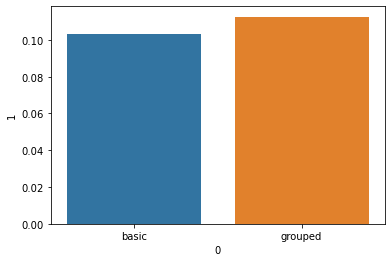

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GroupKFold, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import seaborn as sns

rmse = make_scorer(mean_squared_error, squared=False)

# Prepare y, X
df = df.sample(frac=1, random_state=6345)
y = np.log(df.price)
X = df[xvars].copy()

# Correctly ordered integer encoding
X[cat_vars] = X[cat_vars].apply(lambda x: x.cat.codes)

# Cross-validation
results = {}
rf = RandomForestRegressor(n_estimators=500, max_features="sqrt", 
                           min_samples_leaf=5, n_jobs=-1)
for nm, strategy in zip(("basic", "grouped"), (KFold, GroupKFold)):
    results[nm] = cross_val_score(
        rf, X, y, cv=strategy(), scoring=rmse, groups=df.id
    ).mean()
print(results)

res = pd.DataFrame(results.items())
sns.barplot(x=0, y=1, data=res);